# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum --user


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [17]:
# Load the dataset
df = pd.read_csv('hdb_price_prediction.csv')

# Define continuous columns
continuous_cols = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", 
                   "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]

# Split into training, validation, and testing sets based on year
df_train = df[df["year"] <= 2019][['resale_price'] + continuous_cols]
df_val = df[df["year"] == 2020][['resale_price'] + continuous_cols]
df_test = df[df["year"] == 2021][['resale_price'] + continuous_cols]

# Print details about the datasets
print("Training Data Summary:")
print(f"Number of rows: {df_train.shape[0]}, Number of columns: {df_train.shape[1]}")
print("Columns:", df_train.columns.tolist())
print(df_train.head(), "\n")  # Display the first few rows of the training set

print("Validation Data Summary:")
print(f"Number of rows: {df_val.shape[0]}, Number of columns: {df_val.shape[1]}")
print("Columns:", df_val.columns.tolist())
print(df_val.head(), "\n")  # Display the first few rows of the validation set

print("Testing Data Summary:")
print(f"Number of rows: {df_test.shape[0]}, Number of columns: {df_test.shape[1]}")
print("Columns:", df_test.columns.tolist())
print(df_test.head())  # Display the first few rows of the testing set


Training Data Summary:
Number of rows: 64057, Number of columns: 7
Columns: ['resale_price', 'dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
   resale_price  dist_to_nearest_stn  dist_to_dhoby  degree_centrality  \
0      232000.0             1.007264       7.006044           0.016807   
1      250000.0             1.271389       7.983837           0.016807   
2      262000.0             1.069743       9.090700           0.016807   
3      265000.0             0.946890       7.519889           0.016807   
4      265000.0             1.092551       9.130489           0.016807   

   eigenvector_centrality  remaining_lease_years  floor_area_sqm  
0                0.006243              61.333333            44.0  
1                0.006243              60.583333            67.0  
2                0.002459              62.416667            67.0  
3                0.006243              62.083333            68.0

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# YOUR CODE HERE

target = ['resale_price']
batch_size = 64
num_epochs = 100
learning_rate = 0.001

from torch.utils.data import DataLoader, TensorDataset

# Convert dataframes to PyTorch tensors
X_train = torch.tensor(df_train[continuous_cols].values).float()
y_train = torch.tensor(df_train[target].values).view(-1, 1).float()

X_val = torch.tensor(df_val[continuous_cols].values).float()
y_val = torch.tensor(df_val[target].values).view(-1, 1).float()

X_test = torch.tensor(df_test[continuous_cols].values).float()
y_test = torch.tensor(df_test[target].values).view(-1, 1).float()

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
class B3_Model(nn.Module):
    def __init__(self, no_feature):
        super().__init__()
        self.lin1 = nn.Linear(no_feature, 5)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(5, 5)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(5, 5)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(5, 1)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))
                         
model = B3_Model(no_feature=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
def train(model_inp, num_epochs, optimizer, loss_fn, dataloader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = loss_fn(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0


In [6]:
import os

def train_load_save_model(model_obj, model_path):
    if os.path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model, num_epochs, optimizer, criterion, train_loader)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)
        

SAVED_MODEL_PATH = "saved_models/B3_Model"
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: saved_models/B3_Model


C:\Users\65976\AppData\Roaming\Python\Python312\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


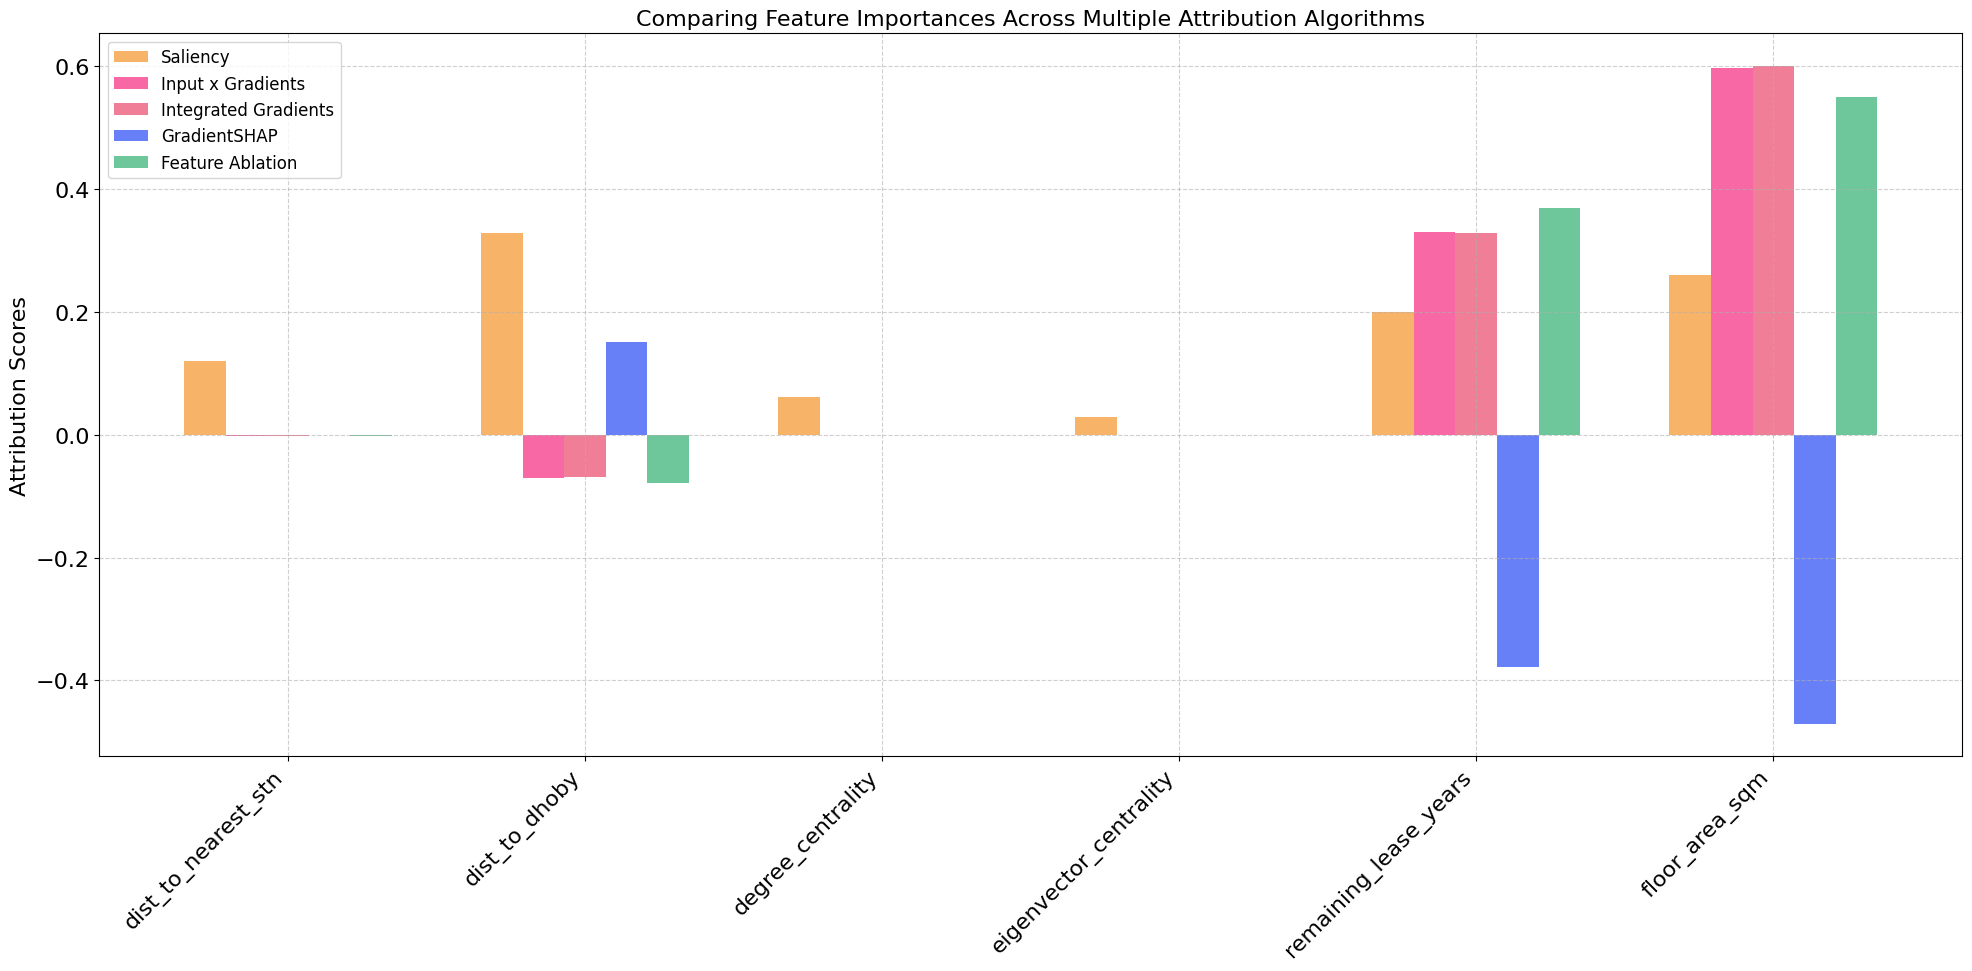

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

# Initialize the attribution algorithms with the model
sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

# Calculate attributions for the first 1000 samples from the test set
sal_attr_test = sal.attribute(X_test[:1000])
ixg_attr_test = ixg.attribute(X_test[:1000])
ig_attr_test = ig.attribute(X_test[:1000], n_steps=50)
gs_attr_test = gs.attribute(X_test[:1000], X_train)
fa_attr_test = fa.attribute(X_test[:1000])

# Summarize attributions by summing over all samples and normalizing
sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

# Define feature names and x-axis labels
feature_names = df_train.drop(target, axis=1).columns
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

# Plot configuration
width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']
colors = ['#f5a142', '#f5428d', '#eb5e7c', '#4260f5', '#49ba81']  # Colors for each bar

plt.figure(figsize=(20, 10))
plt.title('Comparing Feature Importances Across Multiple Attribution Algorithms')
plt.ylabel('Attribution Scores')
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=12)

# Plot bars for each algorithm
ax = plt.subplot()
bars = []
for i, attr_norm_sum in enumerate([sal_attr_test_norm_sum, ixg_attr_test_norm_sum, ig_attr_test_norm_sum, gs_attr_test_norm_sum, fa_attr_test_norm_sum]):
    bar = ax.bar(x_axis_data + i * width, attr_norm_sum, width, alpha=0.8, color=colors[i])
    bars.append(bar)

# Configure ticks and labels
ax.set_xticks(x_axis_data + 2 * width)
ax.set_xticklabels(x_axis_data_labels, rotation=45, ha="right")
plt.legend(legends, loc='best')
plt.grid(True, linestyle='--', alpha=0.6)

# Finalize and display the plot
plt.tight_layout()
plt.show()


3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [8]:
# YOUR CODE HERE

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standard_scaled_X_train = standard_scaler.fit_transform(X_train)
standard_scaled_X_train = torch.tensor(standard_scaled_X_train).float()
standard_scaled_X_val = standard_scaler.transform(X_val)
standard_scaled_X_val = torch.tensor(standard_scaled_X_val).float()

standard_scaled_X_test = standard_scaler.transform(X_test)
standard_scaled_X_test = torch.tensor(standard_scaled_X_test).float()

# Create data loaders
train_dataset = TensorDataset(standard_scaled_X_train, y_train)
val_dataset = TensorDataset(standard_scaled_X_val, y_val)
test_dataset = TensorDataset(standard_scaled_X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = B3_Model(standard_scaled_X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
SAVED_MODEL_PATH = "saved_models/B3_Model_Standard_Scaled"
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: saved_models/B3_Model_Standard_Scaled


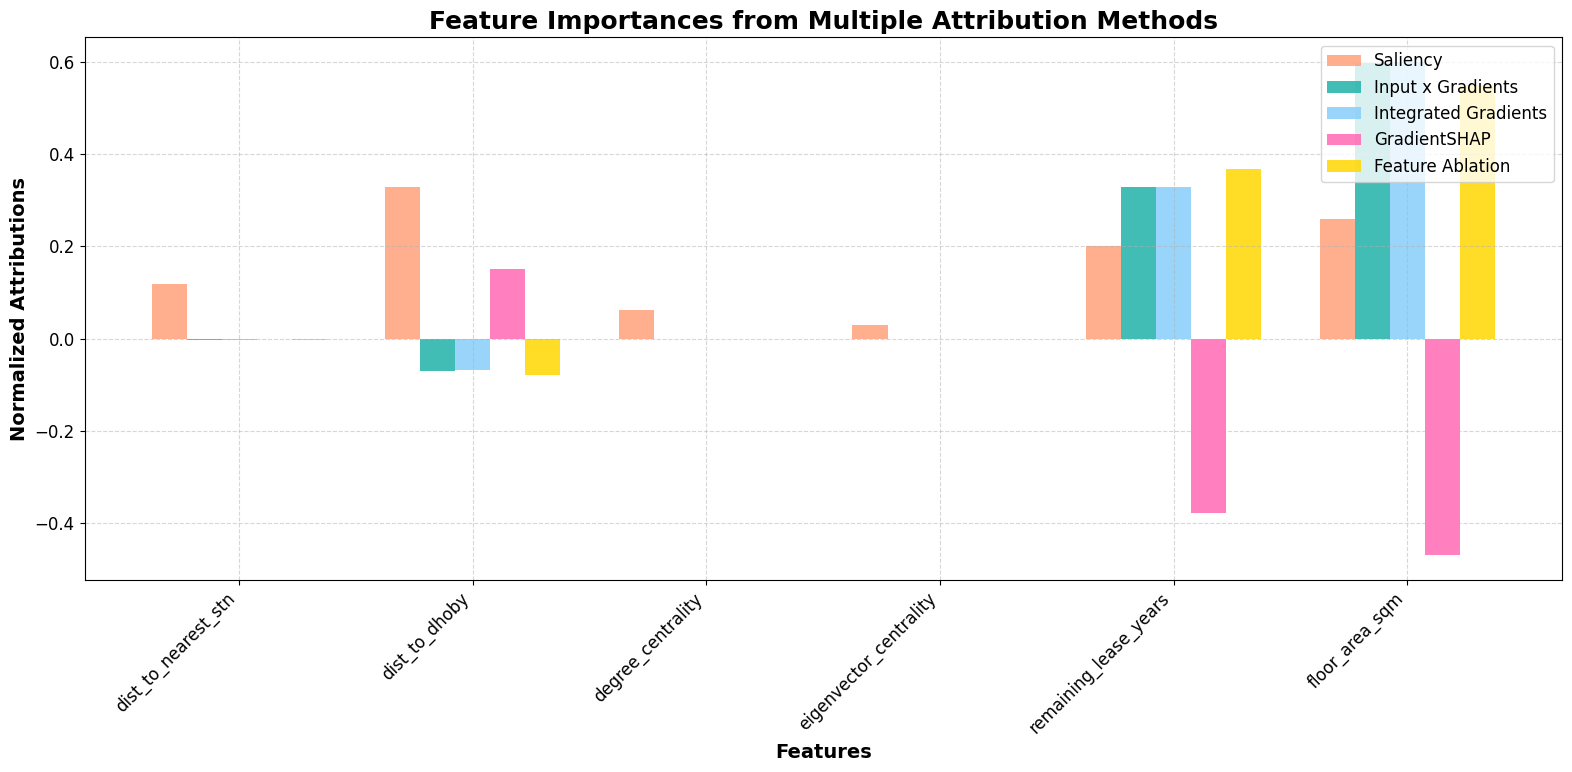

In [21]:
# Set up feature names and x-axis data
feature_names = df_train.drop(target, axis=1).columns
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

# Normalize and calculate the sum of attributions for each method
sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

# Customize plot appearance
width = 0.15  # Adjusted bar width for better spacing
colors = ['#FFA07A', '#20B2AA', '#87CEFA', '#FF69B4', '#FFD700']
legends = ['Saliency', 'Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

# Initialize plot
plt.figure(figsize=(16, 8))
ax = plt.subplot()

# Set plot title and axis labels with different font sizes and weights
ax.set_title('Feature Importances from Multiple Attribution Methods', fontsize=18, fontweight='bold')
ax.set_ylabel('Normalized Attributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Features', fontsize=14, fontweight='bold')

# Define bar plots for each attribution method with distinct colors and transparency
ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.85, color=colors[0])
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.85, color=colors[1])
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.85, color=colors[2])
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center', alpha=0.85, color=colors[3])
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=0.85, color=colors[4])

# Adjust tick parameters for better readability
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Customize x-axis ticks and labels for a clearer layout
ax.set_xticks(x_axis_data + 2 * width)
ax.set_xticklabels(x_axis_data_labels, ha='right', rotation=45)

# Enable grid lines and customize their style
ax.grid(True, linestyle='--', alpha=0.5)

# Display the legend with a different location and font size
plt.legend(legends, loc='upper right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


### Explanation of Saliency and Integrated Gradients (IG) Method Similarities and Differences

Saliency methods, such as gradient-based techniques, often produce scores similar to Integrated Gradients (IG) when:
- The input features have a **linear relationship** with the output.
- The model architecture is relatively **simple**.

This similarity arises because both methods depend on the **gradients** of the model's output with respect to the input features. When gradients remain consistent across the input space, both methods likely generate similar attribution scores.

#### Comparing Saliency and Integrated Gradients:
- **Saliency** provides the gradient of the output with respect to the input.
- **Integrated Gradients (IG)** calculates the accumulated gradients along a path from a baseline to the input, scaled by the difference between them.

For Saliency and IG to produce similar results, gradients along the path used by IG must be **highly consistent**, ensuring that the integral of the gradients (IG) closely matches the direct gradients calculated by Saliency.

#### Observations:
- **Baseline Selection**: Setting the baseline to zero may deviate significantly from the input distribution of certain features, resulting in notable differences between Saliency and IG attribution scores. With a larger dataset, however, this difference might reduce.
- **Data Scaling**: Scaling the data reduces the disparity between Saliency and IG values. Standardizing the input distribution brings the baseline closer to it, leading to more consistent scores.
- **Non-Linear Relationships**: Non-linear relationships captured by IG may contribute to discrepancies from Saliency values. For example:
  - The resale price might **linearly increase** with floor area.
  - The relationship between resale price and distance to the nearest MRT station could be **non-linear** or more than proportional.

In summary, **Saliency and IG** can yield similar results in certain cases, but their differences become more pronounced when non-linear relationships exist or the baseline is far from the input distribution. Scaling can help mitigate some of these discrepancies by standardizing the input data.


5.Why did Input x Gradients give the same attribution scores as IG?


### Input x Gradients (IxG) vs. Integrated Gradients (IG) - A Comparison

**Input x Gradients (IxG)** and **Integrated Gradients (IG)** both rely on gradients, but with a key difference:
- **IxG** multiplies the gradients by the actual input values.
- **IG** accumulates gradients along a path from a baseline to the input.

#### When Are IxG and IG Similar?
- **Consistency in Input Values and Gradients**: When gradients and input values are stable across the input space, IxG can produce results similar to IG.
- **Scaling and Normalization**: If input values are scaled, IxG scores can closely resemble IG scores, as scaling reduces variations from the baseline to the input.

#### Differences and Observations:
- **Minimal Baseline to Input Difference**: If the difference between the baseline and input is small, IG's accumulated gradients contribute minimally, making IxG and IG scores appear more similar.
- **Effect of Scaling**: After scaling, IxG and IG scores may become nearly identical, as scaling aligns the input distribution with the baseline, reducing attribution discrepancies.

In summary, while IxG and IG are often similar, their differences can diminish with consistent inputs and scaled data, aligning them more closely in attribution scores.
